In [1]:
import zipfile
import os, shutil
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)


### Installing the zipped data from googledrive

In [2]:
!pip install gdown
!gdown --id 1f0ZTnzNvUU5R-4ZX-oi8iAkF8zYG-SIs
# https://drive.google.com/file/d/1f0ZTnzNvUU5R-4ZX-oi8iAkF8zYG-SIs/view?usp=drivesdk

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f0ZTnzNvUU5R-4ZX-oi8iAkF8zYG-SIs
To: /kaggle/working/KArSL_18Frames_resized.zip
100%|███████████████████████████████████████| 2.03G/2.03G [00:10<00:00, 201MB/s]


In [3]:
main_path =  "/kaggle/working/"
compressed_file_name = "KArSL_18Frames_resized.zip"
uncompressed_file_name = "KArSL_18Frames_resized"
videos_path = main_path+uncompressed_file_name+"/"

### Methods for unzipping files

In [4]:
def unzip_signer(signer:int):
    file_name = '0' + str(signer)
    if not os.path.exists(file_name):
        with zipfile.ZipFile(file_name + '.zip', 'r') as zip_ref:
            zip_ref.extractall(videos_path)

def remove_unzip_signer(signer:int):
    folder_name = '0' + str(signer)
    if os.path.exists(folder_name):
        shutil.rmtree(folder_name)

def unzip_files():
    if not os.path.exists(main_path + uncompressed_file_name):
        with zipfile.ZipFile(main_path + compressed_file_name, 'r') as zip_ref:
            zip_ref.extractall(main_path)

### Unzip KArSl_18Frames_resized

In [5]:
unzip_files()

### Change the working path to be inside KArSL_18Frames_resized

In [6]:
os.chdir(videos_path)

## Making excell files for data

In [7]:
import pandas as pd
from numpy import asarray
import numpy as np
from tqdm import tqdm

## convert your array into a dataframe
def from_csv_to_array(path):
    df = pd.read_csv(path)
    return df.values.tolist()
    
def from_array_to_csv(filenamee, arr):
    df = pd.DataFrame (np.asarray(arr))
    df.columns = ['VideoPath', 'SignID']
    ## save to xlsx file
    filepath = filenamee
    df.to_csv(filepath, index=False)

## Method for extract all the videos path and their sign id 

In [8]:
def extract_video_info(signer):
    train_file = "0"+str(signer)+"_train.csv"
    test_file = "0"+str(signer)+"_test.csv"

#     if os.path.exists(train_file) and os.path.exists(test_file):
#         train_signer.append(from_csv_to_array(train_file)(x)
#         test_signer.append(from_csv_to_array(test_file)(x)

#     else:
    test_paths = []
    train_paths = []
    for root, dirs, files in os.walk("0"+str(signer)+"/test"):
        for i in dirs:
            if len(i) > 5:
                test_paths.append(["0"+str(signer)+"/test/0"+i[7:10]+'/'+i,i[7:10]])
    from_array_to_csv(test_file, test_paths)
    
    for root, dirs, files in os.walk("0"+str(signer)+"/train"):
        for i in dirs:
            if len(i) > 5:
                train_paths.append(["0"+str(signer)+"/train/0"+i[7:10]+'/'+i,i[7:10]])
    from_array_to_csv(train_file, train_paths)
    
    
    return train_paths, test_paths

In [9]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow import keras

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

import numpy as np
import imageio
import cv2
import os

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available()

Num GPUs Available:  1


True

In [11]:
IMG_SIZE = 256
BATCH_SIZE = 64
EPOCHS = 200

MAX_SEQ_LENGTH = 18
NUM_FEATURES = 2048

### Reading the video as frames

In [12]:
from PIL import Image
import cv2

def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

def framesLodader(videoPath):
    pictures = []
    for i in os.scandir(videoPath):
        if i.is_file():
            pictures.append(asarray(load_image(i.path)))
    return np.array(pictures)

### Extracting the features for video frames

In [13]:
def build_feature_extractor():
    InceptionV3_model = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))

    # preprocess the input
    preprocess_input = keras.applications.inception_v3.preprocess_input(inputs)

    # extract the features from the preprocessed input
    outputs = InceptionV3_model(preprocess_input)

    # form the final model 
    myModel = keras.Model(inputs, outputs, name="feature_extractor")
    
    return myModel


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 3s 0us/step


In [14]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [15]:

class_vocab = pd.read_excel('KARSL-100_Labels.xlsx', header=0)
class_vocab = class_vocab.to_numpy().astype('str')

label_processor = keras.layers.StringLookup(
   vocabulary=np.unique(class_vocab[:,0]), num_oov_indices=1, 
)
print(label_processor.get_vocabulary())

['[UNK]', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


### Prepare the videos by loading the frames and extracting thier features

In [16]:
def prepare_all_videos(videos_path, n=-1):
    """
    Parameters:
        videos_path (str): videos path
        n (int): number of samples
            n = -1 means all videos in that directory
    """
    allVideosFeatures = []
    labels = []
    # 1) For each video.
    counter = 1
    num_vids = len(videos_path) if n == -1 else min(len(videos_path, n))
    for i in tqdm(range(num_vids)):
        path = videos_path[i][0]

        # 2) Gather all its frames
        counter+=1
        frames = framesLodader(path)

        # 4) Extract the CNN features from all video frames
        videoFeatures = feature_extractor.predict(frames, verbose=0)
        seq = videoFeatures.squeeze()
        if seq.shape != (MAX_SEQ_LENGTH, NUM_FEATURES):
            print(videoFeatures.shape, path)
            continue
        # 5) add the extracted features of each video to allVideosFeatures list
        allVideosFeatures.append(seq)

        labels.append(videos_path[i][1])
    labels = np.array(labels)
    allVideosFeatures = np.array(allVideosFeatures)
    return allVideosFeatures, labels

## Extracting Features for a Signer

In [17]:
def extract_features(signer: int, n=-1):
    file_name = '0' + str(signer)
    train_features_file = "train" + file_name + "_features.npy"
    train_labels_file = "train" + file_name + "_labels.npy"
    test_features_file = "test" + file_name + "_features.npy"
    test_labels_file = "test" + file_name + "_labels.npy"


#     if not os.path.exists(train_features_file):
    print("unzip signer", signer)
    unzip_signer(signer)

    print("extract information from signer", signer)
    train_signer, test_signer = extract_video_info(signer)
    print("extract features from signer", signer)
    train_data, train_labels = prepare_all_videos(train_signer, n)
    test_data, test_labels = prepare_all_videos(test_signer, n)

    np.save(train_features_file, train_data)
    np.save(train_labels_file, train_labels)

    np.save(test_features_file, test_data)
    np.save(test_labels_file, test_labels)

#     print("remove unzip signer file", signer)
#     remove_unzip_signer(signer)

## Extract Features From All Signers

In [18]:
for i in range(1,4):
    extract_features(i)

unzip signer 1
extract information from signer 1
extract features from signer 1


 52%|█████▏    | 1829/3506 [03:05<05:15,  5.31it/s]

(15, 2048) 01/train/0127/03_01_0127_(21_10_17_13_52_54)


100%|██████████| 800/800 [01:19<00:00, 10.02it/s]


unzip signer 2
extract information from signer 2
extract features from signer 2


 50%|████▉     | 1779/3566 [03:02<03:57,  7.54it/s]

(10, 2048) 02/train/0160/03_02_0160_(15_11_17_23_34_02)


100%|██████████| 800/800 [01:20<00:00,  9.91it/s]


unzip signer 3
extract information from signer 3
extract features from signer 3


100%|██████████| 800/800 [01:15<00:00, 10.66it/s]


#### shape of labels

In [19]:
# test loading data
np.load("train01_labels.npy").shape

(3505,)


### Creating the sequence model

In [41]:
from tensorflow.keras.layers import GRU, Dropout, Dense
def create_sequence_model():
    class_vocab = label_processor.get_vocabulary()
    
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    x = keras.layers.GRU(40)(frame_features_input)
    x = Dense(512, activation='relu')(x)
    x = Dropout(.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(.5)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(len(class_vocab), activation='softmax')(x)
    
    rnn_model = keras.Model(frame_features_input, output)
    
    adamOptimizer = keras.optimizers.Adam(learning_rate = 1e-4)
    rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer=adamOptimizer, metrics=["accuracy"])
    return rnn_model

def test_model(model,filename, test_data, test_labels):
    model.load_weights(filename)
    _, accuracy = model.evaluate(test_data, test_labels)
    return accuracy

# Utility for running experiments.
def run_experiment(train_data, train_labels, filename, batch_size=320, epochs=20, verbose=False):

    checkpoint = keras.callbacks.ModelCheckpoint(
        filename, save_weights_only=True, save_best_only=True, verbose=verbose)
    earlyStopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)       
   
    # create the RNN model
    seq_model = create_sequence_model()
    X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
    
    # create the RNN model
    seq_model = create_sequence_model()
    
    # start the training
    history = seq_model.fit(
        x = X_train,
        y = y_train,
        validation_data = (X_val,y_val),
        batch_size=batch_size,
        verbose=verbose,
        epochs=epochs,
        callbacks=[checkpoint, earlyStopper])
   
    return history, seq_model

## signer-dependent mode

In [42]:
def dependent(signer:int, verbose=False):
    filename = 'model'+str(signer)
    train_data = np.load(f'train0{signer}_features.npy', allow_pickle=True)
    train_labels = np.load(f'train0{signer}_labels.npy')
    test_data = np.load(f'test0{signer}_features.npy', allow_pickle=True)
    test_labels = np.load(f'test0{signer}_labels.npy')
    
    train_labels = label_processor(train_labels[..., None]).numpy()
    test_labels = label_processor(test_labels[..., None]).numpy()
    
    history, sequence_model = run_experiment(train_data, train_labels, filename=filename,
                                       epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=verbose)
    test_accuracy = test_model(sequence_model, filename, test_data, test_labels)
    
    return sequence_model, history, test_accuracy


In [43]:
dep_models = []
dep_histories = []
dep_tests_acc = []
for i in range(1, 4):
    print("training signer", i)
    model, history, test_acc = dependent(i, 0)
    dep_models.append(model)
    dep_histories.append(history)
    dep_tests_acc.append(test_acc)
    

training signer 1
25/25 [==============================] - 0s 4ms/step - loss: 0.3605 - accuracy: 0.9362
training signer 2
25/25 [==============================] - 0s 4ms/step - loss: 0.0434 - accuracy: 0.9912
training signer 3
25/25 [==============================] - 0s 5ms/step - loss: 0.0049 - accuracy: 0.9987


In [44]:
from matplotlib import pyplot as plt
def print_plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

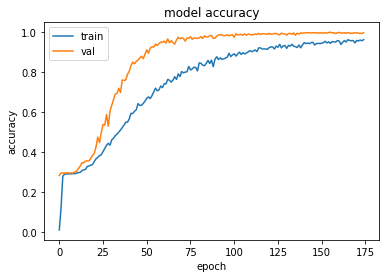

Test accuracy for signer 0: 93.62%



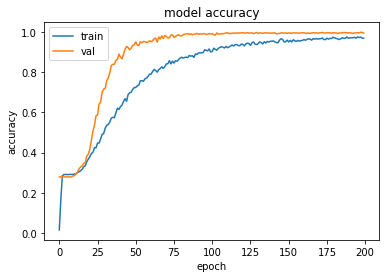

Test accuracy for signer 1: 99.12%



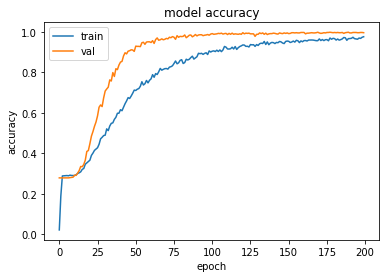

Test accuracy for signer 2: 99.87%



In [45]:
for i in range(0, 3):
    print_plot(dep_histories[i])
    print(f"Test accuracy for signer {i}: {round(dep_tests_acc[i] * 100, 2)}%")
    print()

## signer-independent mode

In [25]:
def independent(signer1:int,signer2:int, signer3, verbose=False):
    filename = 'model'+str(signer1)+"-"+str(signer2)
    train_data = np.concatenate((np.load(f'train0{signer1}_features.npy', allow_pickle=True)
                    ,(np.load(f'train0{signer2}_features.npy', allow_pickle=True))))
        
    train_labels = np.concatenate((np.load(f'train0{signer1}_labels.npy'),(np.load(f'train0{signer2}_labels.npy'))))
        
    test_data = np.load(f'test0{signer3}_features.npy')
    test_labels = np.load(f'test0{signer3}_labels.npy')
    
    train_labels = label_processor(train_labels[..., None]).numpy()
    test_labels = label_processor(test_labels[..., None]).numpy()
    
    history, sequence_model = run_experiment(train_data, train_labels, filename=filename,
                                       epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=verbose)
    test_accuracy = test_model(sequence_model, filename, test_data, test_labels)
    
    return sequence_model, history, test_accuracy


In [26]:
indep_models = []
indep_histories = []
indep_tests_acc = []

model, history, test_acc = independent(2,3,1,0)
indep_models.append(model)
indep_histories.append(history)
indep_tests_acc.append(test_acc)

model, history, test_acc = independent(1,3,2,0)
indep_models.append(model)
indep_histories.append(history)
indep_tests_acc.append(test_acc)

model, history, test_acc = independent(1,2,3,0)
indep_models.append(model)
indep_histories.append(history)
indep_tests_acc.append(test_acc)


25/25 [==============================] - 1s 6ms/step - loss: 8.2589 - accuracy: 0.1688


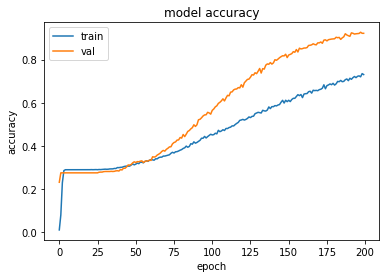

Test accuracy for signer 0: 20.75%



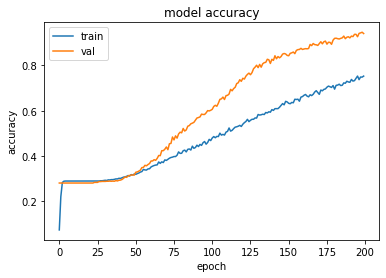

Test accuracy for signer 1: 7.12%



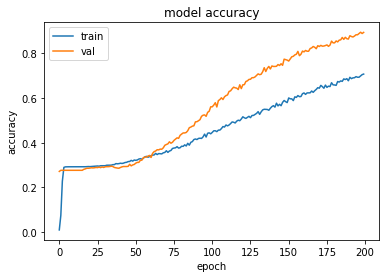

Test accuracy for signer 2: 16.88%



In [27]:
for i in range(0, 3):
    print_plot(indep_histories[i])
    print(f"Test accuracy for signer {i}: {round(indep_tests_acc[i] * 100, 2)}%")
    print()

### Test Model Prediction

In [28]:
train_data = np.load(f'train01_features.npy', allow_pickle=True)
train_labels = np.load(f'train01_labels.npy')

In [29]:
def predict(videos_path):
    probabilities = dep_models[0].predict(videos_path)[0]
    for i in range(len(videos_path)):
        maxi = np.max(probabilities[i])
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

predict(np.array([train_data[0],train_data[1]]))

  ['71' 'هيكل عظمي' 'Skeleton']:  0.15%
  ['72' 'جمجة' 'skull']:  0.49%
